# Machine Learning with the CF data.

Can we predict either FEV1 directly or probably FEV1 class

In [19]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'

from adjustText import adjust_text

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
corrections = {
    "MGI" : {
        '1112926_20171212_S' : '1447437_20171212_S',
        '1128691_20170206_S' : '1128691_20171206_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '1723809_20180227_S' : '1085876_20180227_S',
        '649354_20170206_S' : '639354_20171206_S',
        '652927_20180226_S' : '715927_20180226_S',
        '658355_20180301_S' : '658355_20180327_S',
        '777851_20170918_S' : '778851_20170918_S',
        '788707_20181126_S' : '788707_20181129_S'
    },
    "minion" : {
        '1112926_20171212_S' : '1447437_20171212_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '698917_20190119_S' : '698917_20180119_S'
        }
}

pathogens = {
    "Streptococcus",
    "Staphylococcus",
    "Haemophilus",
    "Mycobacterium",
    "Pseudomonas",
    "Klebsiella",
    "Moraxella",
    "Bordetella",
    "Legionella",
    "Corynebacterium",
    "Chlamydia",
    "Mycoplasma",
    "Neisseria",
    "Burkholderia",
    "Acinetobacter",
    "Francisella",
    "Escherichia",
    "Pasteurella",
    "Nocardia",
    "Actinomyces"
}

def read_taxonomy(tax_file, firstchar, sequence_type):
    """
    Read the taxonomy file and return a data frame
    """

    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None

    df = pd.read_csv(tax_file, sep='\t', compression='gzip')
    df = df[df['taxonomy'].str.contains('k__Bacteria')]
    df = df[~df['taxonomy'].str.endswith(f'{firstchar}__')]
    df = df.set_index('taxonomy')
    df = df.rename(columns=corrections[sequence_type])
    df.index = df.index.str.replace(f'{firstchar}__', '').str.replace('Candidatus ', '')
    df.index = df.index.str.split(';').str[-1]

    df = df.sort_index(axis=1)
    return df

def read_metadata(sequence_type):
    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None

    metadata = pd.read_csv(os.path.join(datadir, "Metadata/Metadata.txt"), encoding='windows-1252', sep="\t", index_col=0)
    metadata = metadata[~metadata[sequence_type].isna()]

    metadata = metadata.rename(columns={'Pseudomonas': 'Pseudomonas Culture'})

    for ix in metadata.index:
        s = metadata.loc[ix, sequence_type]
        if s in corrections[sequence_type]:
            metadata.loc[ix, sequence_type] = corrections[sequence_type][s]
    return metadata

def sorted_presence_absence(df1, df2, minrowsum=0, asc_sort=False):
    """
    Join the two tables and return the sorted version
    """
    # filter so we only include samples sequenced on both MGI and MinION
    common_columns = df1.columns.intersection(df2.columns)
    df1_both = df1[common_columns]
    df2_both = df2[common_columns]

    # create a presence/absence matrix
    df1_presence = (df1_both > 0).astype(int)
    df2_presence = (df2_both > 0).astype(int)*2

    # here we filter on the minimum number of columns each taxa is in if requested
    if minrowsum > 0:
        df1_presence = df1_presence.loc[df1_presence[df1_presence.sum(axis=1) > minrowsum].index]
        df2_presence = df2_presence.loc[df2_presence[df2_presence.sum(axis=1) > (2 * minrowsum)].index]

    # combine the two matrices and sort them
    both = df1_presence.add(df2_presence, fill_value=0)
    sboth = both.loc[both.sum(axis=1).sort_values(ascending=asc_sort).index]
    sboth = sboth.sort_index(axis=1) # sort by column names

    return sboth

In [ ]:
tax='genus'
# read the data

mgi_df = read_taxonomy(os.path.join(datadir, f"MGI/Taxonomy/MGI_reads_{tax}.normalised.tsv.gz"), tax[0], "mgi")
min_df = read_taxonomy(os.path.join(datadir, f"MinION/Taxonomy/Minion_read_based_annotations_{tax}.normalised.tsv.gz"), tax[0], "minion")
mgi_metadata = read_metadata("MGI")
minion_metadata = read_metadata("minion")
# sequence_type = "MGI"
sequence_type = "minion"

if sequence_type == "MGI":
    df = mgi_df.T
    metadata = mgi_metadata
else:
    df = min_df.T
    metadata = minion_metadata

df = df.rename_axis('NAME')
metadata = metadata[~metadata[sequence_type].isna()]

In [ ]:
df.head()

taxonomy,Stahlbacteria,Chromulinivorax,Bradymonas,Microvenator,Acididesulfobacter,Acidulodesulfobacterium,Acanthopleuribacter,Sulfopaludibacter,Edaphobacter,Granulicella,...,Coraliomargarita,Pelagicoccus,Puniceicoccus,Chthoniobacter,Pedosphaera,Akkermansia,Brevifollis,Luteolibacter,Verrucomicrobium,Eremiobacter
NAME,,,,,,,,,,,,,,,,,,,,,
1068841_20180306_S,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128691_20171218_S,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128691_20180116_S,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1282052_20180206_S,0.0,0.0,0.0,0.0,0.0,0.0,13.093975,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1316935_20180417_S,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.index

Index(['1068841_20180306_S', '1128691_20171218_S', '1128691_20180116_S',
       '1282052_20180206_S', '1316935_20180417_S', '1447437_20171006_S',
       '1447437_20171212_S', '1470026_20180502_S', '1565754_20171128_S',
       '1565754_20180403_S', '1586713_20180309_S', '1588281_20180508_S',
       '1590009_20171212_S', '1593967_20180424_S', '1593973_20180427_S',
       '1593973_20180504_S', '1651490_20171010_S', '1651490_20171215_S',
       '1651490_20180206_S', '1834617_20180501_S', '1845116_20180403_S',
       '623361_20180123_S', '639354_20171206_S', '642660_20180601_S',
       '650003_20180207_S', '658355_20171204_S', '658355_20180122_S',
       '658355_20180321_S', '673895_20180122_S', '673895_20180205_S',
       '676138_20180130_S', '698917_20171207_S', '698917_20180119_S',
       '698917_20180128_S', '715927_20180205_S', '748160_20180321_S',
       '748160_20180329_S', '748699_20180329_S', '748699_20180410_S',
       '752797_20170927_S', '753522_20180606_S', '756934_20181218_S',

In [ ]:
# prompt: I have df with the counts of different bacteria, and metadata with the different data. How do I build a machine learning model to identify which different bacteria from df are best at predicting the values in FEV1_RATIO_SCORE in metadata? Both my data frames have a column called Pseudomonas, and I want to call the one from metadata "Culture Pseudomonas"

# Merge the dataframes
merged_df = df.join(metadata[['FEV1_RATIO_SCORE']])

# this data set models just the pathogens
#X = merged_df[list(pathogens)] # Features (bacteria counts)
#y = merged_df['FEV1_RATIO_SCORE'] # Target variable

# this data set models all bacteria
X = merged_df.drop('FEV1_RATIO_SCORE', axis=1)
y = merged_df['FEV1_RATIO_SCORE']

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42, n_estimators = 100) # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)
print("\nFeature Importance:")
feature_importances_sorted

Mean Squared Error: 0.7132960637138327

Feature Importance:


,0
Geobacillus,0.060698
Schaalia,0.044327
Gallibacterium,0.031297
Lactococcus,0.031040
Capnocytophaga,0.030485
...,...
Jingyaoa,0.000000
Hespellia,0.000000
Fusicatenibacter,0.000000
Frisingicoccus,0.000000


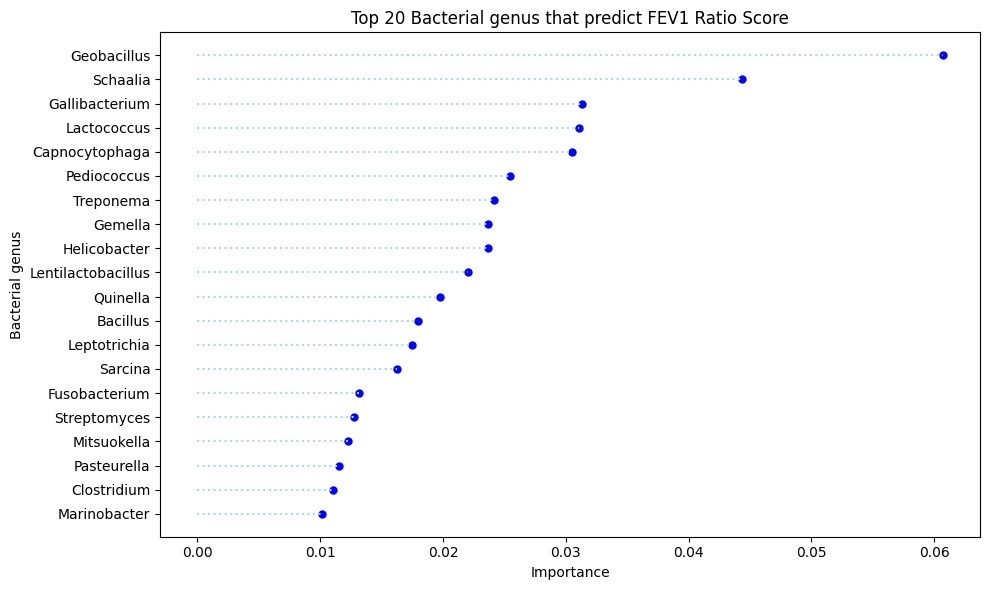

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
top_20_features = feature_importances_sorted.head(20)[::-1]

# Create dotted lines and circles for each feature
for feature, importance in top_20_features.items():
    # plt.plot([0, importance], [feature, feature], linestyle='dotted', marker='o', markersize=5)
    plt.plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    plt.plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

plt.xlabel("Importance")
plt.ylabel(f"Bacterial {tax}")
plt.title(f"Top 20 Bacterial {tax} that predict FEV1 Ratio Score")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## Predict FEV1 Ratio Score Using Pathogenic Bacteria

Mean Squared Error: 0.6150051525961159


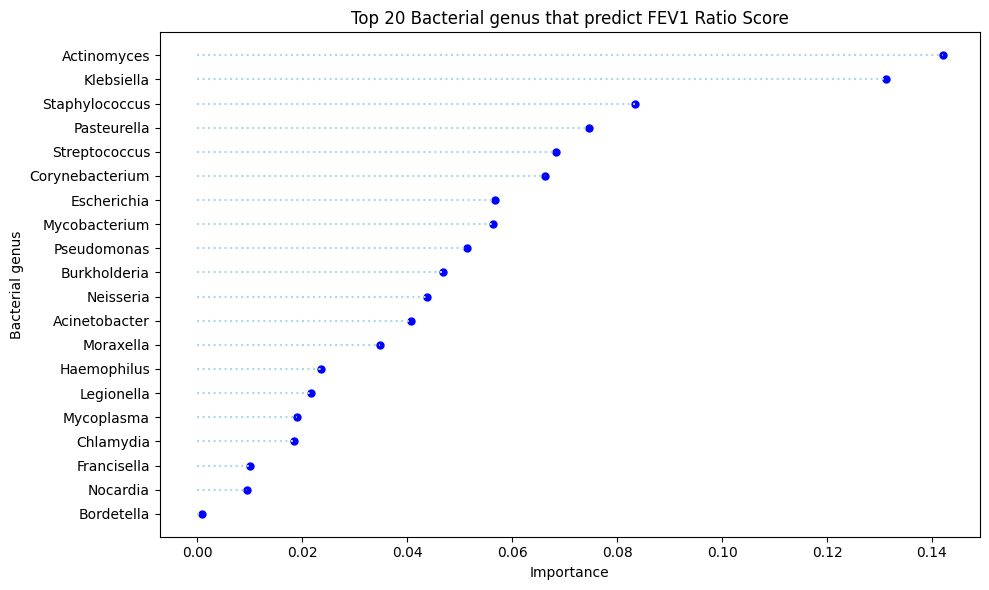

In [ ]:
# Merge the dataframes
merged_df = df.join(metadata[['FEV1_RATIO_SCORE']])

# this data set models just the pathogens
X = merged_df[list(pathogens)] # Features (bacteria counts)
y = merged_df['FEV1_RATIO_SCORE'] # Target variable

# this data set models all bacteria
#X = merged_df.drop('FEV1_RATIO_SCORE', axis=1)
#y = merged_df['FEV1_RATIO_SCORE']

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42, n_estimators = 100) # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    plt.plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    plt.plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

plt.xlabel("Importance")
plt.ylabel(f"Bacterial {tax}")
plt.title(f"Top 20 Bacterial {tax} that predict FEV1 Ratio Score")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Predict FEV1 using pathogenic bacteria

Mean Squared Error for all bacteria: 0.01403979481403157
Mean Squared Error for pathogenic bacteria: 0.012010460388836417


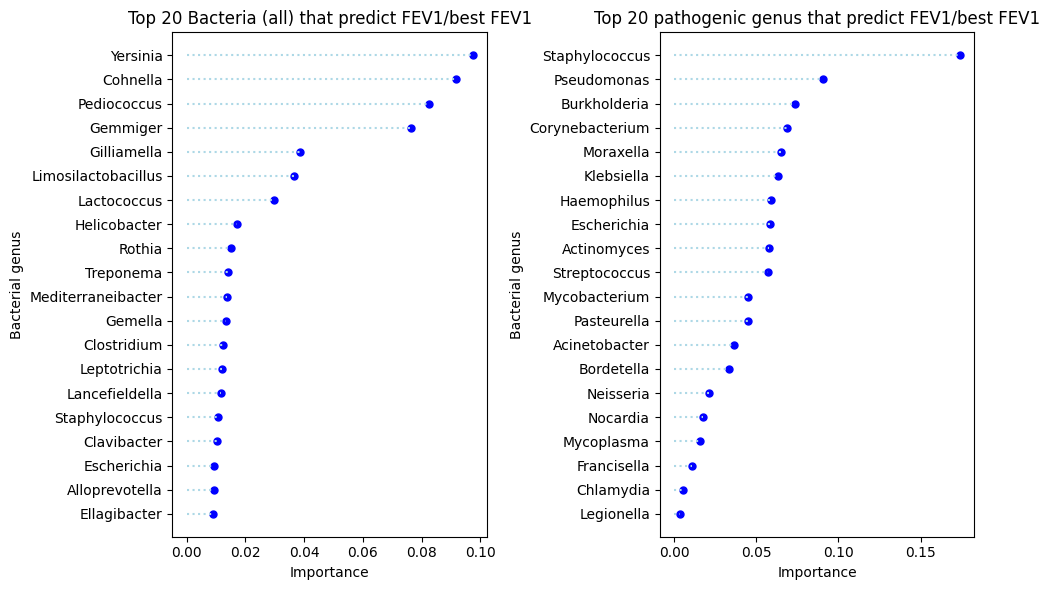

In [ ]:
# Merge the dataframes
intcol = 'FEV1/best FEV1' # interesting column!
merged_df = df.join(metadata[[intcol]])

# this data set models all bacteria
X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42, n_estimators = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for all bacteria: {mse}")

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[:20][::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[0].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[0].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[0].set_xlabel("Importance")
axes[0].set_ylabel(f"Bacterial {tax}")
axes[0].set_title(f"Top 20 Bacteria (all) that predict {intcol}")





# this data set models just the pathogens
X = merged_df[list(pathogens)] # Features (bacteria counts)
y = merged_df[intcol] # Target variable

# this data set models all bacteria
#X = merged_df.drop(intcol, axis=1)
#y = merged_df[intcol]

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for pathogenic bacteria: {mse}")

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[1].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[1].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[1].set_xlabel("Importance")
axes[1].set_ylabel(f"Bacterial {tax}")
axes[1].set_title(f"Top 20 pathogenic {tax} that predict {intcol}")



plt.tight_layout()
plt.show()

In [ ]:
"', '".join(list(metadata.columns))

"minion', 'MGI', 'pwCF_ID', 'Sample date', 'IP vs OP', 'Hospital', 'Room', 'Age', 'Age groups', 'Paediatric vs Adult', 'Gender', 'Sample_Type', 'H2_Uncorrected', 'CH4_Uncorrected', 'CO2', 'H2_Corrected', 'CH4_Corrected', 'CH4/H2 ratio_corrected', 'Corr.', 'Culture Result (Matched with sequenced sample)', 'NTM', 'Pseudomonas Culture', 'Cutured in previous 12 months', 'Others cultured', 'IgE', 'Spec IgE', 'Spec IgG', 'Precipitins', 'FVC', 'FEV1', 'Best FEV1', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank', 'Cystic Fibrosis related diabetes (CFRD)', 'Pancreatic insufficiency (PI)', 'CF gene 1', 'CF gene 2', 'Notes', 'CFLD', 'CS_mucoid', 'CS_non-mucoid', 'CS_Pseudomonas aeruginosa', 'CS_Oral flora', 'CS_Stenophotomonas maltophilia', 'CS_Aspergillus fumigatus', 'CS_Aspergillus flavus', 'CS_Candida albicans', 'CS_Mycobacteroides abscessus', 'CS_Mycobacterium intracellulare', 'CS_Staphylococcus  aureus', 'CS_Inquilinus limosus', 'CS_Achromobacter xylosoxidans', 'CS_Burkholderia

Model Accuracy for using pathogenic bacteria to predict IP vs OP: 0.25
Mean Squared Error for using pathogenic bacteria to predict IP vs OP: 0.19


ValueError: Classification metrics can't handle a mix of binary and continuous targets

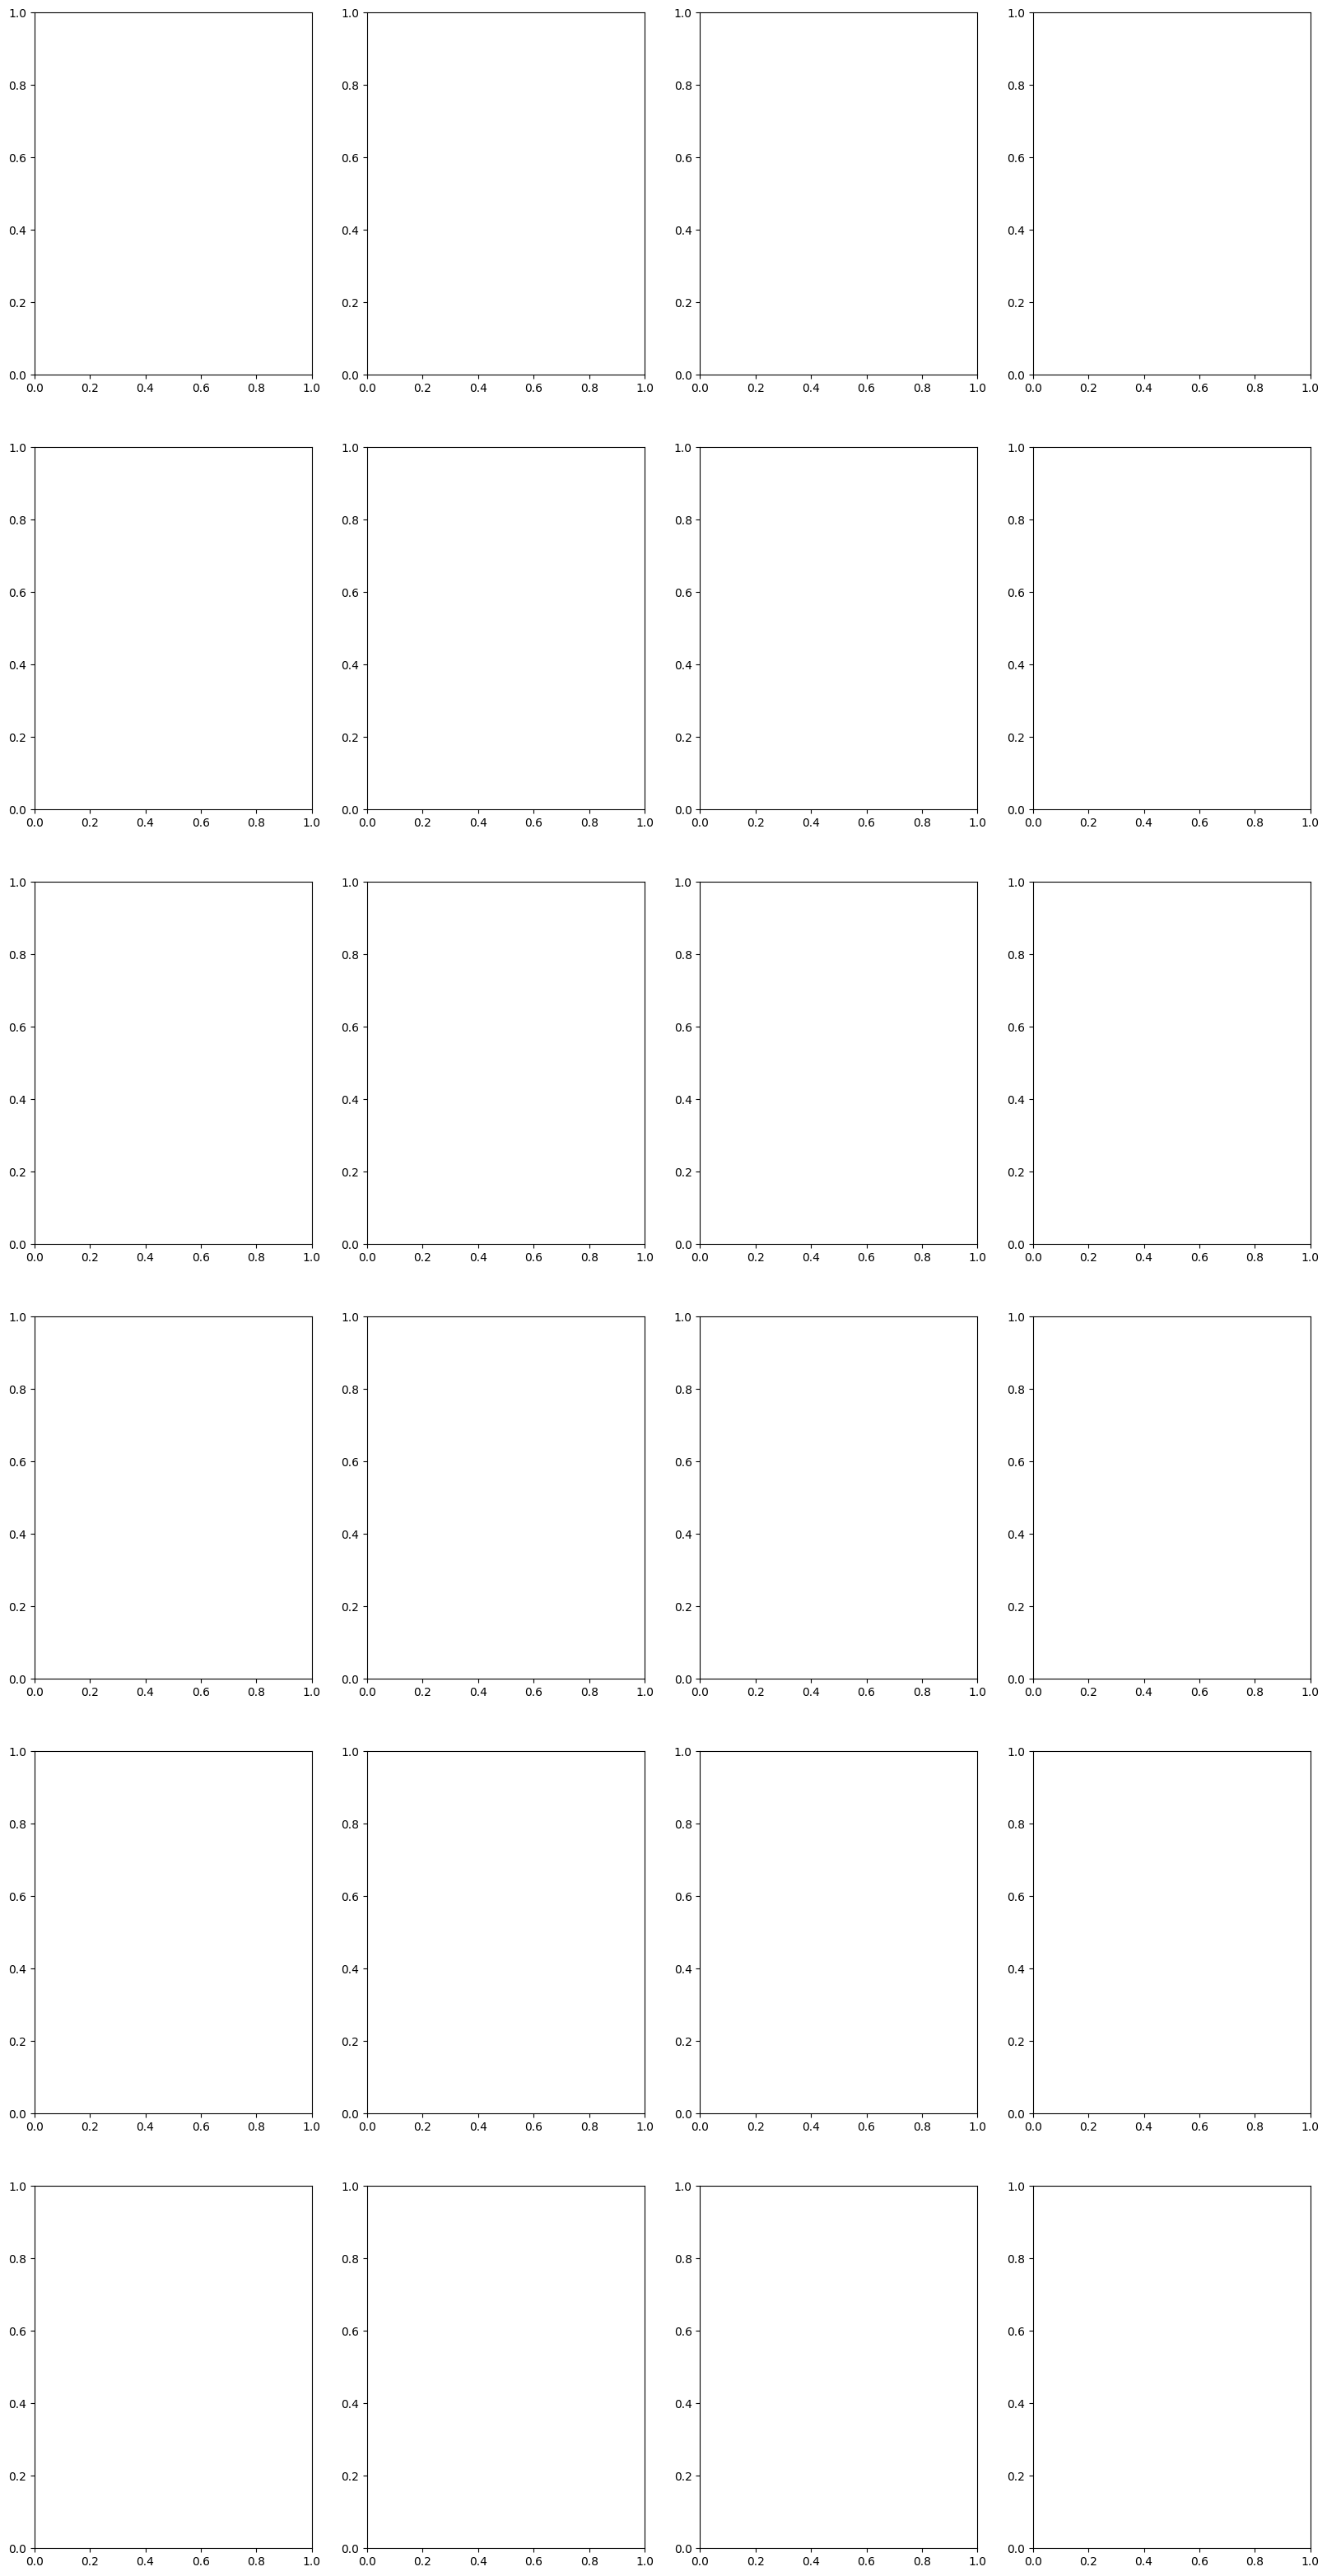

In [ ]:
allintcols = ['IP vs OP', 'Hospital', 'Room', 'Age', 'Age groups', 'Paediatric vs Adult', 'Gender',
              'H2_Corrected', 'CH4_Corrected', 'CH4/H2 ratio_corrected', 'NTM', 'Pseudomonas Culture',
              'IgE', 'Spec IgE', 'Spec IgG', 'Precipitins', 'FVC', 'FEV1', 'Best FEV1', 'FEV1/best FEV1',
              'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank', 'Cystic Fibrosis related diabetes (CFRD)',
              'Pancreatic insufficiency (PI)']

fig, axes = plt.subplots(figsize=(20,40), nrows=6, ncols=4)
model = RandomForestRegressor(random_state=42, n_estimators = 1000)
label_encoder = LabelEncoder()

for i, intcol in enumerate(allintcols):
  ax = axes[i//4, i%4]

  if metadata[intcol].dtype == 'object':
    m = metadata[[intcol]].copy()
    m["enc"] = label_encoder.fit_transform(m[intcol])
    merged_df = df.join(m[["enc"]].dropna(), how='inner')
    merged_df = merged_df.rename(columns={"enc": intcol})
  else:
    merged_df = df.join(metadata[[intcol]].dropna(), how='inner')



  # this data set models just the pathogens
  X = merged_df[list(pathogens)] # Features (bacteria counts)
  y = merged_df[intcol] # Target variable

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy = model.score(X_test, y_test)
  print(f"Model Accuracy for using pathogenic bacteria to predict {intcol}: {accuracy:.2f}")

  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error for using pathogenic bacteria to predict {intcol}: {mse:.2f}")



  # Feature importance
  # This is the default method
  # feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
  # this alternative method uses the permutation importance which _should_ be comparable across models?
  pimmse = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error')
  pim = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=42)
  print(f"Permutation importance Using MSE: {pimmse} Using accuracy: {pim}")
  feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
  feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

  # Create dotted lines and circles for each feature
  for feature in feature_importances_sorted.index[:20][::-1]:
      importance = feature_importances_sorted.loc[feature, 'importance']
      ax.plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
      ax.plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

  ax.set_xlabel("Importance")
  ax.set_ylabel(f"Bacterial {tax}")
  ax.set_title(f"{intcol} (MSE: {mse:.3f})")


plt.tight_layout()
plt.show()


## Testing permutation importance using _Pseudomonas_

Mean Squared Error for all bacteria: 0.20689233333333334
Model Accuracy for using pathogenic bacteria to predict Pseudomonas Culture: -0.49


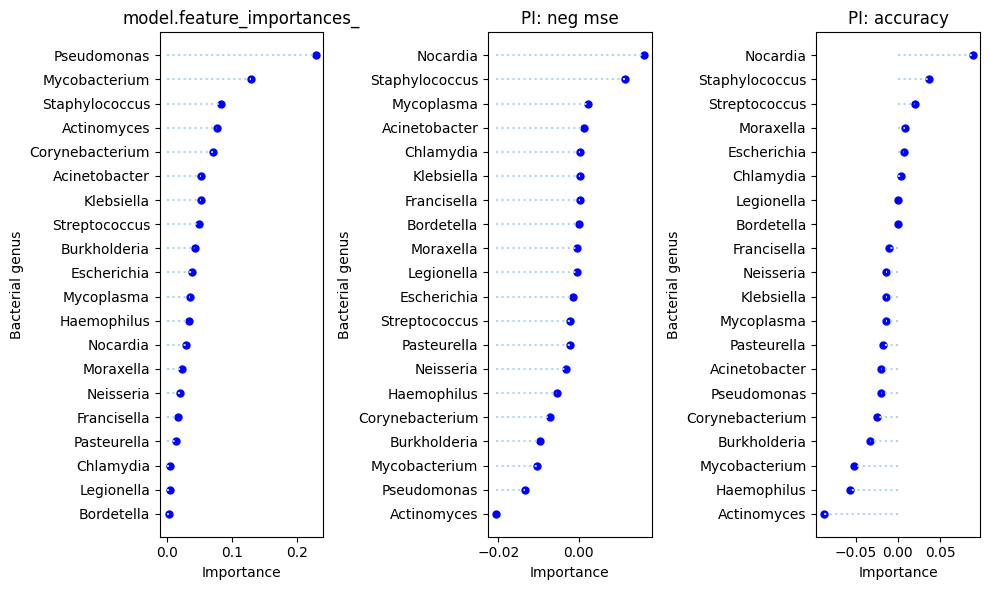

In [17]:
# Merge the dataframes
intcol = 'Pseudomonas Culture' # interesting column!
merged_df = df.join(metadata[[intcol]].astype('category').dropna())

X = merged_df[list(pathogens)]
y = merged_df[intcol].cat.codes

# this data set models all bacteria
#X = merged_df.drop(intcol, axis=1

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42, n_estimators = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for all bacteria: {mse}")

accuracy = model.score(X_test, y_test)
print(f"Model Accuracy for using pathogenic bacteria to predict {intcol}: {accuracy:.2f}")


fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=3)

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[0].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[0].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[0].set_xlabel("Importance")
axes[0].set_ylabel(f"Bacterial {tax}")
axes[0].set_title(f"model.feature_importances_")

# permutation importance

pim = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error')
feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[1].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[1].plot([feature_importances_sorted.min()[0], importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[1].set_xlabel("Importance")
axes[1].set_ylabel(f"Bacterial {tax}")
axes[1].set_title(f"PI: neg mse")


# permutation importance


pim = permutation_importance(model, X_test, y_test, scoring='d2_absolute_error_score', random_state=42)
feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[2].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[2].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[2].set_xlabel("Importance")
axes[2].set_ylabel(f"Bacterial {tax}")
axes[2].set_title(f"PI: accuracy")

plt.tight_layout()
plt.show()

# Random Forest Classifier

The above is with a _REGRESSOR_ not a classifier

Mean Squared Error for all bacteria: 0.3333333333333333
Model Accuracy for using pathogenic bacteria to predict Pseudomonas Culture: 0.67


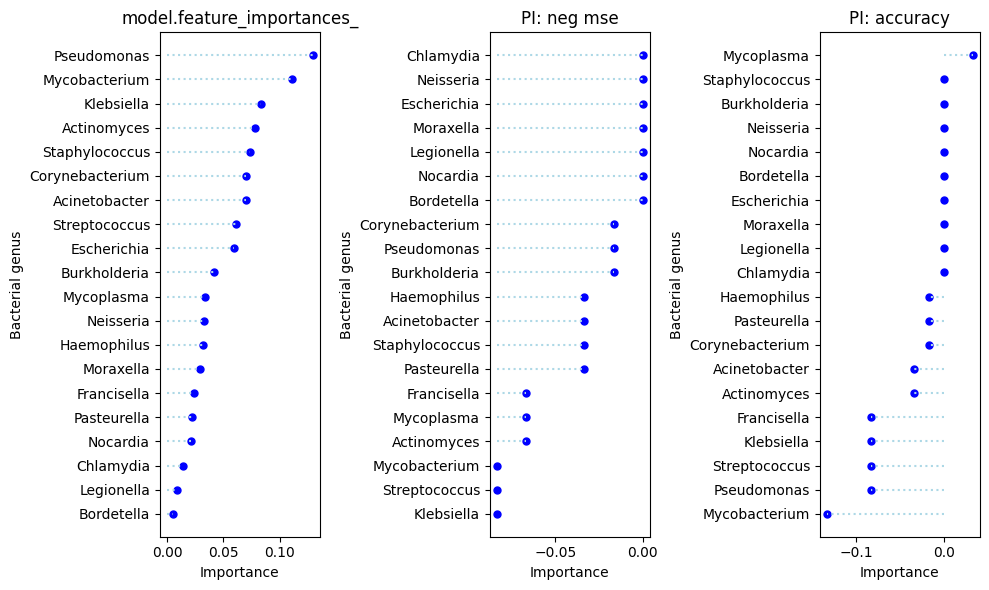

In [21]:
# Merge the dataframes
intcol = 'Pseudomonas Culture' # interesting column!
merged_df = df.join(metadata[[intcol]].astype('category').dropna())

X = merged_df[list(pathogens)]
y = merged_df[intcol]

# this data set models all bacteria
#X = merged_df.drop(intcol, axis=1

# Handle missing values (if any) - replace with mean for simplicity
X = X.fillna(X.mean())
y = y.fillna(y.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42, n_estimators = 1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for all bacteria: {mse}")

accuracy = model.score(X_test, y_test)
print(f"Model Accuracy for using pathogenic bacteria to predict {intcol}: {accuracy:.2f}")


fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=3)

# Feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[0].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[0].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[0].set_xlabel("Importance")
axes[0].set_ylabel(f"Bacterial {tax}")
axes[0].set_title(f"model.feature_importances_")

# permutation importance

pim = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error')
feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[1].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[1].plot([feature_importances_sorted.min()[0], importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[1].set_xlabel("Importance")
axes[1].set_ylabel(f"Bacterial {tax}")
axes[1].set_title(f"PI: neg mse")


# permutation importance


pim = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=42)
feature_importances = pd.DataFrame(pim.importances_mean, index=X.columns, columns=['importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# Create dotted lines and circles for each feature
for feature in feature_importances_sorted.index[::-1]:
    importance = feature_importances_sorted.loc[feature, 'importance']
    axes[2].plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
    axes[2].plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

axes[2].set_xlabel("Importance")
axes[2].set_ylabel(f"Bacterial {tax}")
axes[2].set_title(f"PI: accuracy")

plt.tight_layout()
plt.show()

In [ ]:
print(y.unique())  # Check the unique values in the target
print(y.dtypes)

In [ ]:
y

In [ ]:
feature_importances